In [1]:
import numpy as np 
import pandas as pd

In [2]:
import matplotlib.pylab as plt
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.patches as patches
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from subprocess import check_output
from keras import Sequential
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import KFold
from sklearn.metrics import *
from keras.models import Sequential,Model
from keras.layers import *
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

Using TensorFlow backend.


In [3]:
data = pd.read_csv('voice.csv')
data.head(10)

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male
5,0.132786,0.079557,0.119090,0.067958,0.209592,0.141634,1.932562,8.308895,0.963181,0.738307,...,0.132786,0.110132,0.017112,0.253968,0.298222,0.007812,2.726562,2.718750,0.125160,male
6,0.150762,0.074463,0.160106,0.092899,0.205718,0.112819,1.530643,5.987498,0.967573,0.762638,...,0.150762,0.105945,0.026230,0.266667,0.479620,0.007812,5.312500,5.304688,0.123992,male
7,0.160514,0.076767,0.144337,0.110532,0.231962,0.121430,1.397156,4.766611,0.959255,0.719858,...,0.160514,0.093052,0.017758,0.144144,0.301339,0.007812,0.539062,0.531250,0.283937,male
8,0.142239,0.078018,0.138587,0.088206,0.208587,0.120381,1.099746,4.070284,0.970723,0.770992,...,0.142239,0.096729,0.017957,0.250000,0.336476,0.007812,2.164062,2.156250,0.148272,male
9,0.134329,0.080350,0.121451,0.075580,0.201957,0.126377,1.190368,4.787310,0.975246,0.804505,...,0.134329,0.105881,0.019300,0.262295,0.340365,0.015625,4.695312,4.679688,0.089920,male


In [4]:
print(data.columns)


Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')


In [5]:
label_value_count = data.label.value_counts()
print(label_value_count)
print(data.info())

female    1584
male      1584
Name: label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   316

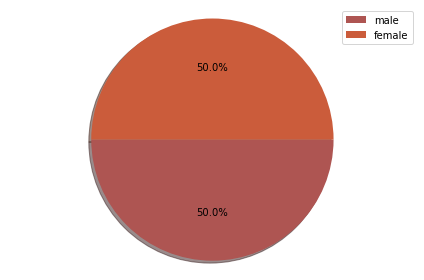

In [24]:
# Create a list of colors (from iWantHue)
colors = ["#AE5552", "#CB5C3B"]
labels= ["male","female"]
# Create a pie chart
plt.pie(data.label.value_counts(),colors=colors, shadow=True, startangle = 180, autopct='%1.1f%%')
plt.legend(labels, loc="best")

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.show()


In [7]:


# Convert string label to float : male = 1, female = 0
dict = {'label':{'male':1,'female':0}}      # label = column name
data.replace(dict,inplace = True)           # replace = str to numerical
x = data.loc[:, data.columns != 'label']
y = data.loc[:,'label']



In [8]:
x.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274


In [9]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

In [10]:
x = x.values
y = y.values

In [11]:
from sklearn.utils import shuffle
x, y = shuffle(x, y, random_state=1010101)

In [12]:
trainX = x[:int(len(x) * 0.7)]
trainY = y[:int(len(y) * 0.7)]
validateX = x[int(len(x) * 0.7) : int(len(x) * 0.9)]
validateY = y[int(len(y) * 0.7) : int(len(y) * 0.9)]
testX = x[int(len(x) * 0.9):]
testY = y[int(len(y) * 0.9):]

print (len(trainX))
print (len(validateX))
print (len(testX))

2217
634
317


In [13]:
trainX = np.array(trainX)
trainY = np.array(trainY)
validateX = np.array(validateX)
validateY = np.array(validateY)
testX = np.array(testX)
testY = np.array(testY)


In [14]:
print (trainX.shape)

(2217, 20)


In [15]:
model = Sequential()
model.add(Dense(len(trainX[0]), input_dim=len(trainX[0]), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [17]:
history = model.fit(trainX, trainY, epochs=1000, batch_size=1000, validation_data = (validateX, validateY))




Train on 2217 samples, validate on 634 samples
Epoch 1/1000





2217/2217 [==============================] - 4s 2ms/step - loss: 0.3424 - acc: 0.5034 - val_loss: 0.2823 - val_acc: 0.4826
Epoch 2/1000
2217/2217 [==============================] - 0s 27us/step - loss: 0.2861 - acc: 0.5101 - val_loss: 0.2751 - val_acc: 0.5252
Epoch 3/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.2811 - acc: 0.4813 - val_loss: 0.2628 - val_acc: 0.5142
Epoch 4/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.2590 - acc: 0.5002 - val_loss: 0.2591 - val_acc: 0.5410
Epoch 5/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.2613 - acc: 0.5309 - val_loss: 0.2498 - val_acc: 0.5000
Epoch 6/1000
2217/2217 [==============================] - 0s 12us/step - loss: 0.2500 - acc: 0.5097 - val_loss: 0.2499 - val_acc: 0.5063
Epoch 7/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.2471 - acc: 0.5237 - val_loss: 0.2441 - val_a

2217/2217 [==============================] - 0s 9us/step - loss: 0.1836 - acc: 0.7289 - val_loss: 0.1785 - val_acc: 0.7334
Epoch 49/1000
2217/2217 [==============================] - 0s 7us/step - loss: 0.1825 - acc: 0.7343 - val_loss: 0.1742 - val_acc: 0.7397
Epoch 50/1000
2217/2217 [==============================] - 0s 7us/step - loss: 0.1803 - acc: 0.7438 - val_loss: 0.1721 - val_acc: 0.7429
Epoch 51/1000
2217/2217 [==============================] - 0s 6us/step - loss: 0.1798 - acc: 0.7456 - val_loss: 0.1716 - val_acc: 0.7461
Epoch 52/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.1779 - acc: 0.7573 - val_loss: 0.1713 - val_acc: 0.7445
Epoch 53/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.1770 - acc: 0.7609 - val_loss: 0.1696 - val_acc: 0.7508
Epoch 54/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.1757 - acc: 0.7618 - val_loss: 0.1675 - val_acc: 0.7587
Epoch 55/1000
2217/2217 [=============================

2217/2217 [==============================] - 0s 7us/step - loss: 0.1195 - acc: 0.8462 - val_loss: 0.1127 - val_acc: 0.8580
Epoch 108/1000
2217/2217 [==============================] - 0s 7us/step - loss: 0.1181 - acc: 0.8489 - val_loss: 0.1134 - val_acc: 0.8580
Epoch 109/1000
2217/2217 [==============================] - 0s 7us/step - loss: 0.1192 - acc: 0.8457 - val_loss: 0.1151 - val_acc: 0.8549
Epoch 110/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.1170 - acc: 0.8498 - val_loss: 0.1121 - val_acc: 0.8580
Epoch 111/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.1162 - acc: 0.8539 - val_loss: 0.1105 - val_acc: 0.8533
Epoch 112/1000
2217/2217 [==============================] - 0s 13us/step - loss: 0.1161 - acc: 0.8484 - val_loss: 0.1086 - val_acc: 0.8659
Epoch 113/1000
2217/2217 [==============================] - 0s 11us/step - loss: 0.1138 - acc: 0.8543 - val_loss: 0.1151 - val_acc: 0.8549
Epoch 114/1000
2217/2217 [====================

Epoch 166/1000
2217/2217 [==============================] - 0s 12us/step - loss: 0.0786 - acc: 0.9039 - val_loss: 0.0757 - val_acc: 0.9054
Epoch 167/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.0787 - acc: 0.9066 - val_loss: 0.0783 - val_acc: 0.9101
Epoch 168/1000
2217/2217 [==============================] - ETA: 0s - loss: 0.0890 - acc: 0.903 - 0s 10us/step - loss: 0.0790 - acc: 0.9166 - val_loss: 0.0824 - val_acc: 0.9148
Epoch 169/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.0807 - acc: 0.9152 - val_loss: 0.0821 - val_acc: 0.9069
Epoch 170/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.0807 - acc: 0.9111 - val_loss: 0.0844 - val_acc: 0.8927
Epoch 171/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.0867 - acc: 0.8877 - val_loss: 0.1004 - val_acc: 0.8707
Epoch 172/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0881 - acc: 0.8908 - val_loss: 0.0784 - val_acc: 

2217/2217 [==============================] - 0s 19us/step - loss: 0.0544 - acc: 0.9418 - val_loss: 0.0539 - val_acc: 0.9416
Epoch 225/1000
2217/2217 [==============================] - 0s 15us/step - loss: 0.0581 - acc: 0.9359 - val_loss: 0.0529 - val_acc: 0.9464
Epoch 226/1000
2217/2217 [==============================] - 0s 24us/step - loss: 0.0556 - acc: 0.9459 - val_loss: 0.0550 - val_acc: 0.9416
Epoch 227/1000
2217/2217 [==============================] - 0s 18us/step - loss: 0.0548 - acc: 0.9427 - val_loss: 0.0538 - val_acc: 0.9448
Epoch 228/1000
2217/2217 [==============================] - 0s 11us/step - loss: 0.0522 - acc: 0.9436 - val_loss: 0.0505 - val_acc: 0.9448
Epoch 229/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.0522 - acc: 0.9418 - val_loss: 0.0516 - val_acc: 0.9448
Epoch 230/1000
2217/2217 [==============================] - 0s 15us/step - loss: 0.0517 - acc: 0.9468 - val_loss: 0.0529 - val_acc: 0.9401
Epoch 231/1000
2217/2217 [================

Epoch 283/1000
2217/2217 [==============================] - 0s 15us/step - loss: 0.0487 - acc: 0.9418 - val_loss: 0.0441 - val_acc: 0.9495
Epoch 284/1000
2217/2217 [==============================] - 0s 14us/step - loss: 0.0471 - acc: 0.9495 - val_loss: 0.0480 - val_acc: 0.9416
Epoch 285/1000
2217/2217 [==============================] - 0s 17us/step - loss: 0.0463 - acc: 0.9481 - val_loss: 0.0417 - val_acc: 0.9527
Epoch 286/1000
2217/2217 [==============================] - 0s 17us/step - loss: 0.0423 - acc: 0.9508 - val_loss: 0.0425 - val_acc: 0.9495
Epoch 287/1000
2217/2217 [==============================] - 0s 18us/step - loss: 0.0449 - acc: 0.9504 - val_loss: 0.0450 - val_acc: 0.9495
Epoch 288/1000
2217/2217 [==============================] - 0s 17us/step - loss: 0.0431 - acc: 0.9576 - val_loss: 0.0426 - val_acc: 0.9527
Epoch 289/1000
2217/2217 [==============================] - 0s 26us/step - loss: 0.0420 - acc: 0.9499 - val_loss: 0.0462 - val_acc: 0.9464
Epoch 290/1000
2217/2217 [=

2217/2217 [==============================] - 0s 14us/step - loss: 0.0467 - acc: 0.9535 - val_loss: 0.0425 - val_acc: 0.9511
Epoch 342/1000
2217/2217 [==============================] - 0s 15us/step - loss: 0.0450 - acc: 0.9450 - val_loss: 0.0429 - val_acc: 0.9543
Epoch 343/1000
2217/2217 [==============================] - 0s 13us/step - loss: 0.0410 - acc: 0.9571 - val_loss: 0.0434 - val_acc: 0.9495
Epoch 344/1000
2217/2217 [==============================] - 0s 13us/step - loss: 0.0427 - acc: 0.9490 - val_loss: 0.0387 - val_acc: 0.9543
Epoch 345/1000
2217/2217 [==============================] - 0s 13us/step - loss: 0.0406 - acc: 0.9567 - val_loss: 0.0383 - val_acc: 0.9543
Epoch 346/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0455 - acc: 0.9463 - val_loss: 0.0394 - val_acc: 0.9574
Epoch 347/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0472 - acc: 0.9522 - val_loss: 0.0392 - val_acc: 0.9558
Epoch 348/1000
2217/2217 [==================

2217/2217 [==============================] - 0s 20us/step - loss: 0.0322 - acc: 0.9635 - val_loss: 0.0341 - val_acc: 0.9590
Epoch 400/1000
2217/2217 [==============================] - ETA: 0s - loss: 0.0256 - acc: 0.973 - 0s 28us/step - loss: 0.0310 - acc: 0.9675 - val_loss: 0.0380 - val_acc: 0.9574
Epoch 401/1000
2217/2217 [==============================] - 0s 14us/step - loss: 0.0324 - acc: 0.9639 - val_loss: 0.0339 - val_acc: 0.9590
Epoch 402/1000
2217/2217 [==============================] - 0s 14us/step - loss: 0.0300 - acc: 0.9684 - val_loss: 0.0333 - val_acc: 0.9606
Epoch 403/1000
2217/2217 [==============================] - 0s 14us/step - loss: 0.0301 - acc: 0.9702 - val_loss: 0.0346 - val_acc: 0.9606
Epoch 404/1000
2217/2217 [==============================] - 0s 7us/step - loss: 0.0303 - acc: 0.9666 - val_loss: 0.0341 - val_acc: 0.9621
Epoch 405/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0333 - acc: 0.9621 - val_loss: 0.0343 - val_acc: 0.9606
Epoch 

Epoch 458/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.0364 - acc: 0.9571 - val_loss: 0.0330 - val_acc: 0.9621
Epoch 459/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.0308 - acc: 0.9635 - val_loss: 0.0358 - val_acc: 0.9574
Epoch 460/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.0379 - acc: 0.9581 - val_loss: 0.0380 - val_acc: 0.9558
Epoch 461/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.0359 - acc: 0.9590 - val_loss: 0.0320 - val_acc: 0.9606
Epoch 462/1000
2217/2217 [==============================] - 0s 11us/step - loss: 0.0322 - acc: 0.9648 - val_loss: 0.0321 - val_acc: 0.9590
Epoch 463/1000
2217/2217 [==============================] - 0s 7us/step - loss: 0.0308 - acc: 0.9680 - val_loss: 0.0343 - val_acc: 0.9558
Epoch 464/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.0288 - acc: 0.9698 - val_loss: 0.0325 - val_acc: 0.9606
Epoch 465/1000
2217/2217 [=====

Epoch 517/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.0357 - acc: 0.9599 - val_loss: 0.0418 - val_acc: 0.9527
Epoch 518/1000
2217/2217 [==============================] - 0s 12us/step - loss: 0.0320 - acc: 0.9639 - val_loss: 0.0406 - val_acc: 0.9479
Epoch 519/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.0377 - acc: 0.9540 - val_loss: 0.0545 - val_acc: 0.9243
Epoch 520/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.0409 - acc: 0.9517 - val_loss: 0.0525 - val_acc: 0.9306
Epoch 521/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0383 - acc: 0.9526 - val_loss: 0.0369 - val_acc: 0.9527
Epoch 522/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.0377 - acc: 0.9567 - val_loss: 0.0451 - val_acc: 0.9432
Epoch 523/1000
2217/2217 [==============================] - 0s 14us/step - loss: 0.0411 - acc: 0.9549 - val_loss: 0.0382 - val_acc: 0.9543
Epoch 524/1000
2217/2217 [==

2217/2217 [==============================] - 0s 10us/step - loss: 0.0248 - acc: 0.9725 - val_loss: 0.0319 - val_acc: 0.9653
Epoch 577/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0283 - acc: 0.9684 - val_loss: 0.0368 - val_acc: 0.9495
Epoch 578/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.0276 - acc: 0.9698 - val_loss: 0.0329 - val_acc: 0.9653
Epoch 579/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0269 - acc: 0.9707 - val_loss: 0.0332 - val_acc: 0.9621
Epoch 580/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0262 - acc: 0.9729 - val_loss: 0.0331 - val_acc: 0.9606
Epoch 581/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.0280 - acc: 0.9675 - val_loss: 0.0395 - val_acc: 0.9511
Epoch 582/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.0298 - acc: 0.9666 - val_loss: 0.0341 - val_acc: 0.9621
Epoch 583/1000
2217/2217 [====================

2217/2217 [==============================] - 0s 25us/step - loss: 0.0283 - acc: 0.9675 - val_loss: 0.0375 - val_acc: 0.9558
Epoch 636/1000
2217/2217 [==============================] - 0s 22us/step - loss: 0.0326 - acc: 0.9621 - val_loss: 0.0466 - val_acc: 0.9448
Epoch 637/1000
2217/2217 [==============================] - 0s 17us/step - loss: 0.0397 - acc: 0.9535 - val_loss: 0.0423 - val_acc: 0.9527
Epoch 638/1000
2217/2217 [==============================] - 0s 26us/step - loss: 0.0338 - acc: 0.9585 - val_loss: 0.0380 - val_acc: 0.9543
Epoch 639/1000
2217/2217 [==============================] - 0s 22us/step - loss: 0.0320 - acc: 0.9648 - val_loss: 0.0306 - val_acc: 0.9637
Epoch 640/1000
2217/2217 [==============================] - 0s 30us/step - loss: 0.0272 - acc: 0.9702 - val_loss: 0.0318 - val_acc: 0.9653
Epoch 641/1000
2217/2217 [==============================] - 0s 17us/step - loss: 0.0256 - acc: 0.9698 - val_loss: 0.0322 - val_acc: 0.9621
Epoch 642/1000
2217/2217 [================

2217/2217 [==============================] - 0s 9us/step - loss: 0.0221 - acc: 0.9761 - val_loss: 0.0321 - val_acc: 0.9590
Epoch 695/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0230 - acc: 0.9743 - val_loss: 0.0298 - val_acc: 0.9669
Epoch 696/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.0225 - acc: 0.9765 - val_loss: 0.0327 - val_acc: 0.9621
Epoch 697/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.0248 - acc: 0.9729 - val_loss: 0.0294 - val_acc: 0.9653
Epoch 698/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0226 - acc: 0.9770 - val_loss: 0.0300 - val_acc: 0.9637
Epoch 699/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0228 - acc: 0.9770 - val_loss: 0.0299 - val_acc: 0.9685
Epoch 700/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.0232 - acc: 0.9752 - val_loss: 0.0315 - val_acc: 0.9590
Epoch 701/1000
2217/2217 [=====================

2217/2217 [==============================] - 0s 17us/step - loss: 0.0232 - acc: 0.9743 - val_loss: 0.0288 - val_acc: 0.9669
Epoch 754/1000
2217/2217 [==============================] - 0s 20us/step - loss: 0.0218 - acc: 0.9765 - val_loss: 0.0314 - val_acc: 0.9637
Epoch 755/1000
2217/2217 [==============================] - 0s 16us/step - loss: 0.0238 - acc: 0.9752 - val_loss: 0.0287 - val_acc: 0.9653
Epoch 756/1000
2217/2217 [==============================] - 0s 14us/step - loss: 0.0218 - acc: 0.9761 - val_loss: 0.0299 - val_acc: 0.9637
Epoch 757/1000
2217/2217 [==============================] - 0s 17us/step - loss: 0.0218 - acc: 0.9765 - val_loss: 0.0286 - val_acc: 0.9685
Epoch 758/1000
2217/2217 [==============================] - 0s 14us/step - loss: 0.0214 - acc: 0.9756 - val_loss: 0.0305 - val_acc: 0.9621
Epoch 759/1000
2217/2217 [==============================] - 0s 11us/step - loss: 0.0215 - acc: 0.9770 - val_loss: 0.0292 - val_acc: 0.9685
Epoch 760/1000
2217/2217 [================

Epoch 812/1000
2217/2217 [==============================] - 0s 18us/step - loss: 0.0215 - acc: 0.9774 - val_loss: 0.0295 - val_acc: 0.9685
Epoch 813/1000
2217/2217 [==============================] - 0s 29us/step - loss: 0.0244 - acc: 0.9734 - val_loss: 0.0299 - val_acc: 0.9653
Epoch 814/1000
2217/2217 [==============================] - 0s 14us/step - loss: 0.0214 - acc: 0.9774 - val_loss: 0.0298 - val_acc: 0.9653
Epoch 815/1000
2217/2217 [==============================] - 0s 16us/step - loss: 0.0215 - acc: 0.9770 - val_loss: 0.0291 - val_acc: 0.9669
Epoch 816/1000
2217/2217 [==============================] - 0s 17us/step - loss: 0.0209 - acc: 0.9774 - val_loss: 0.0322 - val_acc: 0.9637
Epoch 817/1000
2217/2217 [==============================] - 0s 17us/step - loss: 0.0243 - acc: 0.9738 - val_loss: 0.0326 - val_acc: 0.9606
Epoch 818/1000
2217/2217 [==============================] - 0s 20us/step - loss: 0.0245 - acc: 0.9729 - val_loss: 0.0293 - val_acc: 0.9621
Epoch 819/1000
2217/2217 [=

2217/2217 [==============================] - 0s 7us/step - loss: 0.0196 - acc: 0.9797 - val_loss: 0.0305 - val_acc: 0.9621
Epoch 872/1000
2217/2217 [==============================] - 0s 10us/step - loss: 0.0213 - acc: 0.9765 - val_loss: 0.0284 - val_acc: 0.9685
Epoch 873/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0207 - acc: 0.9770 - val_loss: 0.0304 - val_acc: 0.9653
Epoch 874/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.0202 - acc: 0.9783 - val_loss: 0.0303 - val_acc: 0.9637
Epoch 875/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0212 - acc: 0.9783 - val_loss: 0.0284 - val_acc: 0.9669
Epoch 876/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0196 - acc: 0.9811 - val_loss: 0.0297 - val_acc: 0.9653
Epoch 877/1000
2217/2217 [==============================] - 0s 13us/step - loss: 0.0201 - acc: 0.9779 - val_loss: 0.0304 - val_acc: 0.9621
Epoch 878/1000
2217/2217 [=====================

2217/2217 [==============================] - 0s 9us/step - loss: 0.0295 - acc: 0.9675 - val_loss: 0.0317 - val_acc: 0.9637
Epoch 931/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0241 - acc: 0.9725 - val_loss: 0.0295 - val_acc: 0.9653
Epoch 932/1000
2217/2217 [==============================] - 0s 14us/step - loss: 0.0243 - acc: 0.9734 - val_loss: 0.0310 - val_acc: 0.9637
Epoch 933/1000
2217/2217 [==============================] - 0s 17us/step - loss: 0.0291 - acc: 0.9644 - val_loss: 0.0317 - val_acc: 0.9590
Epoch 934/1000
2217/2217 [==============================] - 0s 15us/step - loss: 0.0237 - acc: 0.9738 - val_loss: 0.0292 - val_acc: 0.9606
Epoch 935/1000
2217/2217 [==============================] - 0s 13us/step - loss: 0.0232 - acc: 0.9725 - val_loss: 0.0292 - val_acc: 0.9637
Epoch 936/1000
2217/2217 [==============================] - 0s 13us/step - loss: 0.0234 - acc: 0.9734 - val_loss: 0.0294 - val_acc: 0.9621
Epoch 937/1000
2217/2217 [==================

2217/2217 [==============================] - 0s 8us/step - loss: 0.0226 - acc: 0.9756 - val_loss: 0.0310 - val_acc: 0.9621
Epoch 989/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.0218 - acc: 0.9756 - val_loss: 0.0276 - val_acc: 0.9685
Epoch 990/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.0190 - acc: 0.9806 - val_loss: 0.0278 - val_acc: 0.9669
Epoch 991/1000
2217/2217 [==============================] - 0s 9us/step - loss: 0.0189 - acc: 0.9811 - val_loss: 0.0285 - val_acc: 0.9669
Epoch 992/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.0209 - acc: 0.9761 - val_loss: 0.0332 - val_acc: 0.9590
Epoch 993/1000
2217/2217 [==============================] - 0s 12us/step - loss: 0.0225 - acc: 0.9761 - val_loss: 0.0286 - val_acc: 0.9669
Epoch 994/1000
2217/2217 [==============================] - 0s 8us/step - loss: 0.0186 - acc: 0.9811 - val_loss: 0.0282 - val_acc: 0.9669
Epoch 995/1000
2217/2217 [======================

In [18]:
predictions = model.predict(testX)


In [19]:
prob = []
limit_prob = []

for k in range(len(predictions)):
    prob.append(round(predictions[k][0], 4))
    if round(predictions[k][0], 4) > 0.5:
        limit_prob.append(1)
    else:
        limit_prob.append(0)

In [20]:
my_submission = pd.DataFrame({'real': testY, 'prediction': prob, 'limit prediction' : limit_prob})
# you could use any filename. We choose submission here
my_submission.to_csv('sample_submission1.csv', index=False)

In [21]:
my_submission.head(50)

,real,prediction,limit prediction
0,0,0.0000,0
1,1,0.9980,1
2,1,1.0000,1
3,1,0.9984,1
4,1,0.9980,1
5,1,0.9833,1
6,1,0.9985,1
7,0,0.0134,0
8,0,0.0160,0
9,1,0.9328,1
